<a href="https://colab.research.google.com/github/aniketmaurya/pytorch-gans/blob/main/pix2pix/Pix2Pix_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q pytorch-lightning

     |████████████████████████████████| 819kB 7.5MB/s 
     |████████████████████████████████| 829kB 22.4MB/s 
     |████████████████████████████████| 112kB 35.4MB/s 
     |████████████████████████████████| 276kB 34.7MB/s 
     |████████████████████████████████| 1.3MB 36.3MB/s 
     |████████████████████████████████| 296kB 55.5MB/s 
     |████████████████████████████████| 143kB 55.0MB/s 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
try:
    from rich import print
except: pass

In [3]:
from torch.utils.data import Dataset
from torchvision.transforms.functional import center_crop
import os
from glob import glob
from pathlib import Path
from PIL import Image

In [5]:
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20

display_step = 200
batch_size = 4
lr = 0.0002
target_size = 256
device = 'cuda'

In [6]:
import pytorch_lightning as pl

In [52]:
def show_tensor_images(image_tensor,
                       num_images=25,
                       size=(3, 64, 64),
                       ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[2].imshow(fake)
    ax[1].imshow(real)
    plt.show()

In [8]:
from torchvision import transforms

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

In [10]:
# http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
path = './facades/train/'

class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path)/'*'))
        self.target_size = target_size
        
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]        
        
        real = image[:, :, :image_width // 2]
        condition = image[:, :, image_width // 2:]
        
        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)
        
        return real, condition
    
    
dataset = FacadesDataset(path, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
transforms.functional.to_pil_image(dataset[0][0])
transforms.functional.to_pil_image(dataset[0][0]).size
dataset[0][0].shape

torch.Size([3, 256, 256])

In [11]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, use_dropout=False, use_bn=True):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.activation = nn.LeakyReLU(0.2)

#         if use_bn:
#             self.batchnorm = nn.BatchNorm2d(out_channels)
#         self.use_bn = use_bn

#         if use_dropout:
#             self.dropout = nn.Dropout(0.5)
#         self.use_dropout = use_dropout

#     def forward(self, x):
#         x = self.conv1(x)
#         if self.use_bn:
#             x = self.batchnorm(x)
#         if self.use_dropout:
#             x = self.dropout(x)
#         x = self.activation(x)
#         return x


# class UpSampleConv(nn.Module):
#     def __init__(self, input_channels, use_dropout=False, use_bn=True):
#         super().__init__()
#         self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
#         self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
#         self.conv2 = nn.Conv2d(
#             input_channels, input_channels // 2, kernel_size=3, padding=1
#         )
#         self.conv3 = nn.Conv2d(
#             input_channels // 2, input_channels // 2, kernel_size=2, padding=1
#         )
#         if use_bn:
#             self.batchnorm = nn.BatchNorm2d(input_channels // 2)
#         self.use_bn = use_bn
#         self.activation = nn.ReLU()
#         if use_dropout:
#             self.dropout = nn.Dropout()
#         self.use_dropout = use_dropout

#     def forward(self, x, skip_con_x):

#         x = self.upsample(x)
#         x = self.conv1(x)
#         skip_con_x = center_crop(skip_con_x, x.shape[-2:])
#         x = torch.cat([x, skip_con_x], axis=1)
#         x = self.conv2(x)
#         if self.use_bn:
#             x = self.batchnorm(x)
#         if self.use_dropout:
#             x = self.dropout(x)
#         x = self.activation(x)
#         x = self.conv3(x)
#         if self.use_bn:
#             x = self.batchnorm(x)
#         if self.use_dropout:
#             x = self.dropout(x)
#         x = self.activation(x)
#         return x


# class DownSampleConv(nn.Module):
#     def __init__(self, in_channels, use_dropout=False, use_bn=False):
#         super().__init__()

#         self.conv_block1 = ConvBlock(in_channels, in_channels * 2, use_dropout, use_bn)
#         self.conv_block2 = ConvBlock(
#             in_channels * 2, in_channels * 2, use_dropout, use_bn
#         )
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self, x):
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = self.maxpool(x)
#         return x


- Let Ck denote a Convolution-BatchNorm-ReLU layer with k filters.

- CDk denotes a Convolution-BatchNorm- Dropout-ReLU layer with a dropout rate of 50%.

- All convolutions are 4×4 spatial filters applied with stride 2.

- Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2.

In [12]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)
        
        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
            
        if activation:
            self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

encoder = DownSampleConv(3, 16)
assert encoder(torch.randn(1, 3, 256, 256)).shape[-2:] == (128, 128)

In [13]:
class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True, dropout=False):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)
        
        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
            
        if activation:
            self.act = nn.ReLU(True)
        
        if dropout:
            self.drop = nn.Dropout2d(0.5)
        
        
    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)
        
        if self.dropout:
            x = self.drop(x)
        return x
    
decoder = UpSampleConv(3, 16)
assert decoder(torch.randn(1, 3, 256, 256)).shape[-2:] == (512, 512)

In [14]:
decoder(torch.randn(2, 3, 256, 256)).shape

torch.Size([2, 16, 512, 512])

In [15]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()
        
        # encoder/donwsample convs
        self.encoders = [
                DownSampleConv(in_channels, 64, batchnorm=False), # bs x 64 x 128 x 128
                DownSampleConv(64, 128), # bs x 128 x 64 x 64
                DownSampleConv(128, 256), # bs x 256 x 32 x 32
                DownSampleConv(256, 512), # bs x 512 x 16 x 16
                DownSampleConv(512, 512), # bs x 512 x 8 x 8
                DownSampleConv(512, 512), # bs x 512 x 4 x 4
                DownSampleConv(512, 512), # bs x 512 x 2 x 2
                DownSampleConv(512, 512, batchnorm=False), # bs x 512 x 1 x 1
        ]
        
        # decoder/upsample convs
        self.decoders = [
                UpSampleConv(512, 512, dropout=True), # bs x 512 x 2 x 2
                UpSampleConv(1024, 512, dropout=True), # bs x 512 x 4 x 4
                UpSampleConv(1024, 512, dropout=True), # bs x 512 x 8 x 8
                UpSampleConv(1024, 512), # bs x 512 x 16 x 16
                UpSampleConv(1024, 256), # bs x 256 x 32 x 32
                UpSampleConv(512, 128), # bs x 128 x 64 x 64
                UpSampleConv(256, 64), # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        
        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)
        

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)
            
            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]
        
        i = 0
        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            assert self.decoder_channels[i]==x.shape[1], f'{x.shape, self.decoder_channels[i]}'
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)
            i+=1
            
        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [16]:
gen = Generator(3, 3)

In [17]:
gen(torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 3, 256, 256])

In [18]:
gen = Generator(3, 3)

In [19]:
gen(torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 3, 256, 256])

In [20]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [21]:
# C64-C128-C256-C512

In [22]:
disc = PatchGAN(3*2)

In [23]:
disc(torch.randn(1, 3, 256, 256), torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 1, 16, 16])

In [24]:
disc(torch.randn(1, 3, 256, 256), torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 1, 16, 16])

In [25]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [26]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [58]:
class Pix2Pix(pl.LightningModule):
    def __init__(self,
                 in_channels,
                 out_channels,
                 hidden_channels=32,
                 depth=6,
                 learning_rate=0.0002,
                 lambda_recon=200):

        super().__init__()
        self.save_hyperparameters()

        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)
        
        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%1==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            display_progress(condition[0], fake[0], real[0])
        return loss

In [59]:
pix2pix = Pix2Pix(3, 3)

In [60]:
trainer = pl.Trainer(max_epochs=1000, gpus=1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [61]:
# trainer.save_checkpoint("epoch-59.ckpt")
pix2pix = Pix2Pix.load_from_checkpoint("epoch-59.ckpt")


  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 54.4 M
1 | patch_gan             | PatchGAN          | 2.8 M 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.713   Total estimated model params size (MB)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


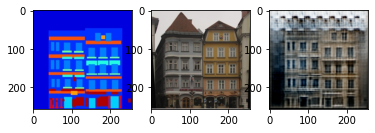

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


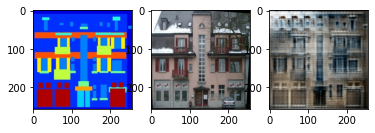

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


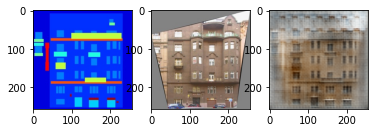

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


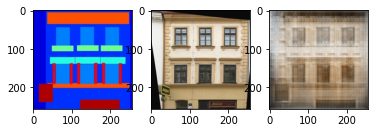

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


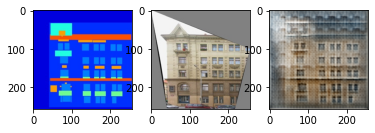

In [ ]:
trainer.fit(pix2pix, dataloader)